In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import cirq
import cirq_superstaq as css
import ldpc
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pymatching
import sinter
import stim
import stimcirq
from custom_decoder import BPOSD, CustomDecoder

import qldpc

In [8]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-5, -1.5, 10)
code_name = "Unrotated Surface Code"
sector = qldpc.objects.Pauli.X
file_name = f"{('_'.join(code_name.split())).lower()}_{sector}"
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3, 5, 7]:
            code = qldpc.codes.SurfaceCode(d, rotated=False)
            # circuit = gen_syndrome_surface_circuit(code, sector=sector, repetitions=d).with_noise(NoiseModel(noise))
            # stim_circuit = stimcirq.cirq_circuit_to_stim_circuit(circuit)
            stim_circuit = qldpc.simulator.get_syndrome_extraction_circuit(code, noise, sector, d)
            # print(circuit)
            yield sinter.Task(
                circuit=stim_circuit,
                detector_error_model=stim_circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )

def run_simulation(overwrite=True):

    filename = f'bposd_{file_name}.csv'
    
    if overwrite:
        if pathlib.Path(filename).is_file():
            pathlib.Path(filename).unlink()

    samples = sinter.collect(
        num_workers=10,
        max_shots=10_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        # decoders=["pymatching"],
        decoders=['bposd'],
        custom_decoders={'bposd': CustomDecoder(BPOSD)
        },

        print_progress=True,
        save_resume_filepath=filename,
    )
    return(samples)

In [9]:
samples = run_simulation()

Starting 10 workers...
Finding work...
Running...
    bposd processes=3  ~core_mins_left=1       shots_left=6600     errors_left=100     {d=3,noise=1e-05,repetitions=3}
    bposd processes=3  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=5,noise=1e-05,repetitions=5}
    bposd processes=2  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=7,noise=1e-05,repetitions=7}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=3,noise=2.4484367468222292e-05,repetitions=3}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=5,noise=2.4484367468222292e-05,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=2.4484367468222292e-05,repetitions=7}
    bposd processes=0  ~core_mins_left=1       shots_left=9900     errors_left=100     {d=3,noise=5.994842503189409e-05,repetitions=3}
    bposd processes=0  ~core_mins_left=1       sho

In [12]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    sinter.plot_error_rate(
        ax=axis,
        stats=samples,
        group_func=lambda stat: f"{code_name} d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        # filter_func=lambda stat: stat.decoder == "pymatching",
        x_func=lambda stat: stat.json_metadata['noise'],
    )

    axis.set_ylabel('Logical Error Rate')
    axis.set_title(f'{code_name} threshold with BPOSD for {sector} stabilizers')

    axis.plot(noise_range, noise_range, "--", color="k")
    axis.loglog()
    axis.grid()
    axis.set_xlabel('Physical Error Rate')
    axis.legend()

    # Save to file and also open in a window.
    fig.savefig(f'{file_name}_plot.png')
    plt.show()

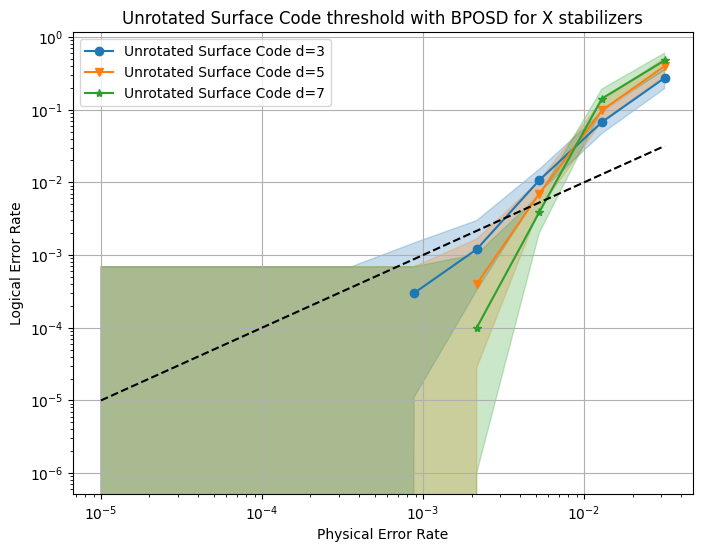

In [13]:
plot_results(samples)

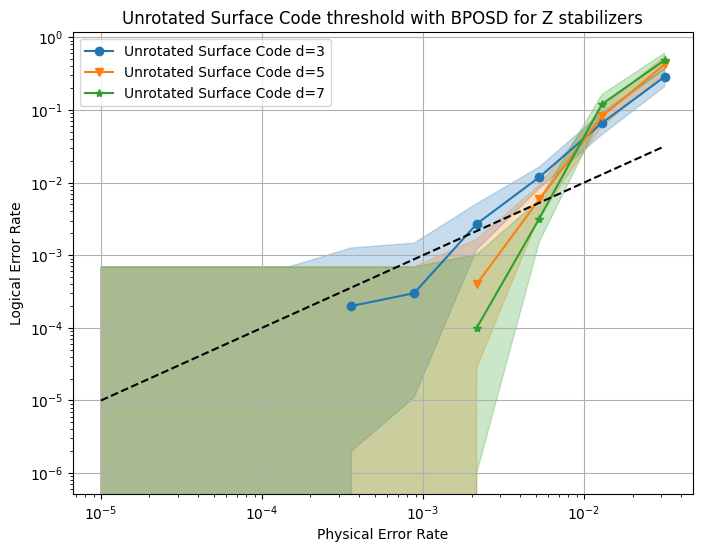

In [7]:
plot_results(samples)